In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate

### Alternative to the standar method for solving TOV, inspired on the newtonian case worked by astrophysicists.

## System of Equations

The equations of structure of an compact object with spherical symmetry (neutron stars in our case) is given by (in units where $c=G=1$):

$$ P=P(\rho), $$
$$ \frac{dm}{dr}=4\pi \rho r^2 , $$
$$ \frac{dP}{dr}=-(\rho+P)\frac{m+4\pi r^3 P}{r(r-2m)} , $$

Keeping the same nondimensionalization:
$$r=b\bar{r} \quad ; \quad \rho=\Sigma \bar{\rho} \quad ; \quad m=m_c\bar{m} \quad ; \quad  P=P_c \bar{P}$$

$$ \Sigma=\frac{m_{n}^{4}c^{3}}{8 \pi^2 \hbar^3}\quad;\quad b=\frac{c}{\sqrt{\Sigma G}}\quad, \quad m= \frac{b c^2}{G} \bar{m} \quad; \quad P= \Sigma c^2 \bar{P},$$

we have the system of equations

$$ \bar{P}=\bar{P}(\bar{\rho}), $$
$$ \frac{d\bar{m}}{\bar{dr}}=4\pi \bar{\rho} \bar{r}^2 , $$
$$ \frac{d\bar{P}}{d\bar{r}}=-\left(\bar{\rho}+\bar{P}\right)\frac{\bar{m}+4\pi \bar{r}^3 \bar{P}}{\bar{r}(\bar{r}-2\bar{m})} . $$

We want to change the independent variable to $m$, we find the reciprocal to the second equation:

$$\frac{d\bar{r}}{d\bar{m}}=\frac{1}{4\pi\bar{\rho}\bar{r}^2}\quad \longrightarrow \quad \frac{1}{d\bar{r}}=\frac{4\pi \bar{\rho} \bar{r}^2}{dm},$$

and replacing it in the third we have the system in the form:

$$ \bar{P}=\bar{P}{\left(\bar{\rho}\right)}  \quad  ; \quad \bar{\rho}=\bar{\rho}{\left(\bar{P}\right)} $$

$$ \frac{d\bar{P}}{d\bar{m}} = -\frac{\left(\bar{\rho}+\bar{P}\right)}{4\pi\bar{r}^3\bar{\rho}} \frac{\bar{m}+4\pi\bar{P}\bar{r}^3}{(\bar{r}-2\bar{m})} $$

$$ \frac{d\bar{r}}{d\bar{m}}=\frac{1}{4\pi\bar{\rho}\bar{r}^2} $$

## Solving the system

In [2]:
import Physical_Const as phys
h=phys.h 
c=phys.c
G=phys.G
Msun=phys.Msun
mn=phys.mn # Neutron mass


Sigma=mn**4.0*c**3.0/(8.0*np.pi**2*(h/(2.0*np.pi))**3.0)
br=c/np.sqrt(Sigma*G) 
Mdim=(br*c**2.0/G)/Msun # So that m is measured in Solar masses

In [3]:
Sigma

2280831545249651.0

In [4]:
Mdim

16.464490729612635

In [5]:
br

2430587.054706729

In [6]:
rhoEoS,PEoS=np.loadtxt('EOSFull_NL3_BPS02.dat',usecols=(0,1),unpack=True) 

# Interpolating P
EoS_NL302=interpolate.interp1d(rhoEoS/Sigma,PEoS/(c**2.0*Sigma)) 


# Interpolating Rho
EoS_NL3=interpolate.interp1d(PEoS/(c**2.0*Sigma),rhoEoS/Sigma)

def rho_EoS(x):
    rhorho=interpolate.interp1d(PEoS/(c**2.0*Sigma),rhoEoS/Sigma)
    return rhorho(x)

In [7]:
def TOV(m,y):
    rns = y[0]
    pns = y[1]
    #print(pns,rho_EoS(pns))
    dpdm=-((pns+rho_EoS(pns))*(m+4.0*np.pi*pns*(rns**3.0)))/(4.0*np.pi*rho_EoS(pns)*(rns**3.0)*(rns-2.0*m))
    drdm=1.0/(4.0*np.pi*(rns**2.0)*rho_EoS(pns))
    return [drdm,dpdm]

# Stellar structure

# Mass-radius relation

In [13]:
def StaticSeqMR(y0,m0,dm):
    Static=integrate.ode(TOV).set_integrator('lsoda',atol=1e-15) # Dopri (Dorman-Prince method) is a R-K method of order (4)5
    Static.set_initial_value(y0,m0)
    #global mms,pexs,rs
    #mms=[]; pexs=[];rs=[]
    #rs.append(y0[0]); pexs.append(y0[1]); mms.append(m0)
    while Static.successful() and Static.y[1] > 1e-9:
       # print(Static.y[1],rho_EoS(Static.y[1]),dm,'w')
        Static.integrate(Static.t+dm)
    rstar=Static.y[0]
    mstar=Static.t 
    return [mstar*Mdim,rstar*br*1e-5] 
    # Returns mass of the star in solar masses and radius of the star in km

In [23]:
#Initial values
dm1=1e-8# Step size
m01=0 # Initial point
r0=1e-7
rhoc=np.arange(14.1,15.4,0.05)
xc=EoS_NL302((10.0**rhoc)/Sigma) 

In [20]:
MM=[];RR=[]

for xcc in xc:
    MR=StaticSeqMR([r0,xcc],m01,dm1/5)
    print(MR)
    RR=RR+[MR[1]]
    MM=MM+[MR[0]]

[0.12529428050933897, 24.239880827957972]
[0.1577616964450757, 19.724347900119152]
[0.2001921379449407, 17.38973799231036]
[0.2532019696826518, 16.10812991738882]
[0.31697430967237017, 15.393565823098418]
[0.38973560301257876, 14.996699677042125]
[0.4741286638993587, 14.764255944731298]
[0.5738862887399815, 14.641295683522458]
[0.6934046282728658, 14.57126896053221]
[0.8417011523499479, 14.55545236548274]
[1.0263581540960012, 14.578250753176262]
[1.2561857824958043, 14.63689254284674]
[1.5230090227586295, 14.693924320039374]
[1.802504059517887, 14.732117850803224]
[2.0662041834648375, 14.72441373551202]
[2.2896511302016633, 14.650623112658222]
[2.4656390507194352, 14.53312771261392]
[2.596558984218612, 14.367372043662556]
[2.688905678353885, 14.173679789886906]
[2.749928020312929, 13.969460342553344]
[2.7863302519303685, 13.753510640205404]
[2.8035188180242407, 13.525274079828897]
[2.8058910218473145, 13.31525188948258]
[2.79685988646808, 13.09762825717129]
[2.779200205436718, 12.88287

ValueError: A value in x_new is below the interpolation range.

In [18]:
StaticSeqMR([1e-7,xc[16]],m01,dm1/2)

[2.4656390673480226, 14.538465484399783]

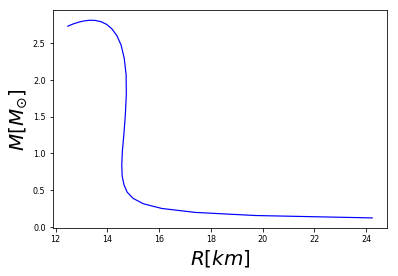

In [22]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(RR, MM,'b-', linewidth=1.2) 
plt.xlabel(r'$R [km]$')
plt.ylabel(r'$M [M_{\odot}]$')
plt.savefig('MRrel_NL3.png', format='png', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()